<a href="https://colab.research.google.com/github/charlesm93/nested-rhat/blob/main/rhat_locker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\hat R$ locker

This notebook serves as a sandbox to understand the potential of the nested-$\hat R$ diagnostic. The underlying idea is to gather short chains into a long "super chains" and then check that the super chains are mixing. We'll motivate this idea and work out details, benefits and limitations. 

This file is an updated version of an original notebook released by Google Research (https://github.com/google-research/google-research/tree/master/nested_rhat, Copyright 2021 Google LLC.)

Revision to this notebook were made by Charles C. Margossian (Copyright 2022 Charles C. Margossian)

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# Import tf first to enable eager mode.
# import tensorflow as tf
# tf.executing_eagerly()

In [ ]:
!rm -Rf probability
!rm -Rf fun_mc
!rm -Rf inference_gym
!git clone https://github.com/tensorflow/probability.git
!mv probability/spinoffs/fun_mc/fun_mc .
!mv probability/spinoffs/inference_gym/inference_gym .
!pip install tf-nightly tfp-nightly jax jaxlib

!pip install immutabledict

In [ ]:
# TODO (charlesm93): check which of these actually need to be imported.

import numpy as np
from matplotlib.pyplot import *
# %config InlineBackend.figure_format = 'retina'
# matplotlib.pyplot.style.use("dark_background")

import jax
from jax import random
from jax import numpy as jnp

# from colabtools import adhoc_import

from inference_gym import using_jax as gym

# from tensorflow_probability.spinoffs.fun_mc import using_jax as fun_mcmc
from fun_mc import using_jax as fun_mcmc


# import tensorflow as tf
from tensorflow_probability.python.internal import prefer_static as ps
from tensorflow_probability.python.internal import unnest


import tensorflow_probability as _tfp
tfp = _tfp.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

tfp_np = _tfp.substrates.numpy
tfd_np = tfp_np.distributions 

In [ ]:
# set font size for matplot lib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

In [ ]:
import tensorflow as tf
tf.executing_eagerly()

True

In [ ]:
# Allows figures to rend latex
# !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \usepackage{amsfonts}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

In [ ]:
from google.colab import files  # use this download saved plots

In [ ]:
import matplotlib.pyplot as plt

## Set up problem

In [ ]:
# options: Bananas, GermanCredit, Brownian
problem_name = 'Bananas'

if (problem_name == 'Bananas'):
  target = gym.targets.VectorModel(gym.targets.Banana(),
                                    flatten_sample_transformations=True)
  num_dimensions = target.event_shape[0]  
  init_step_size = 1.

if (problem_name == 'GermanCredit'):
  # This problem seems to require that we load TF datasets first.
  import tensorflow_datasets
  target = gym.targets.VectorModel(gym.targets.GermanCreditNumericSparseLogisticRegression(),
                                    flatten_sample_transformations=True)
  num_dimensions = target.event_shape[0]
  init_step_size = 0.02

if (problem_name == 'Brownian'):
  target = gym.targets.BrownianMotionMissingMiddleObservations()
  target = gym.targets.VectorModel(target,
                                    flatten_sample_transformations = True)
  num_dimensions = target.event_shape[0]
  init_step_size = 0.01

def target_log_prob_fn(x):
  """Unnormalized, unconstrained target density.

  This is a thin wrapper that applies the default bijectors so that we can
  ignore any constraints.
  """
  y = target.default_event_space_bijector(x)
  fldj = target.default_event_space_bijector.forward_log_det_jacobian(x)
  return target.unnormalized_log_prob(y) + fldj

# NOTE: use a large factor to get overdispered initializations.
# NOTE: don't set offset to 0 when the target mean is 0.
# CHECK: what scale should we use? Poor inits can make the problem much more
# difficult.
# NOTE: we probably want inits that allow us to get decent estimates
# in the long regime

# if (problem_name == 'Bananas'):
if (problem_name == 'Bananas'):
  offset = 2
  def initialize (shape, key = random.PRNGKey(37272709)):
    return 3 * random.normal(key, shape + (num_dimensions,)) + offset

if (problem_name == 'GermanCredit'):
  offset = 0.1
  def initialize (shape, key = random.PRNGKey(37272709)):
    return 0.5 * random.normal(key, shape + (num_dimensions,)) + offset

# offset = 0.5
# def initialize (shape, key = random.PRNGKey(37272709)):
#   return 0.01 * random.normal(key, shape + (num_dimensions,)) + offset


/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:4488: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


## Run MCMC
We consider two regimes: the "long" regime in which a few chains are run for many warmup and sampling iterations, and the "short" regime, wherein many chains are run for a few warmup and sampling iterations. Note that in the short regime we're willing to not warmup our chains (i.e. possibly adapt step size, trajectory length, mass matrix) as well as in the long regime, the hope being that the variance decreases enough because we're running many chains. 

In [ ]:
# Transition kernel for long regime
num_chains_long = 4
if (problem_name == 'GermanCredit'):
  num_warmup_long, num_sampling_long = 500, 1000
if (problem_name == 'Bananas'):
  num_warmup_long, num_sampling_long = 200, 1000
total_samples_long = num_warmup_long + num_sampling_long

# CHECK: is this the transition kernel we want to use?
# REMARK: the step size is picked based on the model we're fitting
if (problem_name == 'Bananas' or problem_name == 'GermanCredit'): 
  kernel_long = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, init_step_size, 1)
  kernel_long = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(kernel_long, num_warmup_long)
  kernel_long = tfp.mcmc.DualAveragingStepSizeAdaptation(
      kernel_long, num_warmup_long, target_accept_prob = 0.75,
      reduce_fn=tfp.math.reduce_log_harmonic_mean_exp)

# Follow the inference gym tutorial
# NOTE: transition kernel below is untested.
if (problem_name == 'Brownian'):
  kernel_long = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, init_step_size, 1)
  # Adapt step size.
  kernel_long = tfp.mcmc.DualAveragingStepSizeAdaptation(
    kernel_long, num_warmup_long, # int(num_samples // 2 * 0.8),
    target_accept_prob = 0.9)
  # Adapt trajectory length.
  kernel_long = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(
    kernel_long,
    num_adaptation_steps = num_warmup_long) # int(num_steps // 2 * 0.8))


# TODO: work out what an appropriate transition kernel for this problem would be.
# if (problem_name == 'GermanCredit'):
#   kernel_long = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, init_step_size, 1)
#   kernel_long = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(kernel_long, num_warmup_long)
#   kernel_long = tfp.mcmc.DualAveragingStepSizeAdaptation(
#       kernel_long, num_warmup_long, target_accept_prob = 0.75,
#       reduce_fn=tfp.math.reduce_log_harmonic_mean_exp)

initial_state = initialize((num_chains_long,))

In [ ]:
# initial_state = initialize((num_chains_long,))
result_long = tfp.mcmc.sample_chain(
  total_samples_long, initial_state, kernel = kernel_long, seed = random.PRNGKey(1954))

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [ ]:
# Transition kernel for short regime
# CHECK: how many warmup iterations should we use here?
# Suggested options: 512, 1024, 2048, 2500
num_chains_short = 512
num_super_chains = 4

if (problem_name == 'GermanCredit'):
  num_warmup_short, num_sampling_short = 1000, 1000
if (problem_name == 'Bananas'):
  num_warmup_short, num_sampling_short = 100, 1000  # 100, 1000
total_samples_short = num_warmup_short + num_sampling_short

if (problem_name == 'Bananas' or problem_name == 'GermanCredit'):
  kernel_short = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, init_step_size, 1)
  kernel_short = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(kernel_short, num_warmup_short)
  kernel_short = tfp.mcmc.DualAveragingStepSizeAdaptation(
      kernel_short, num_warmup_short, target_accept_prob = 0.75,  #0.75,
      reduce_fn = tfp.math.reduce_log_harmonic_mean_exp)

different_location = False

if (different_location):
  # initialize each chain at a different location 
  initial_state = initialize((num_chains_short,))

else:
  # Chains within a super chain are all initialized at the same location
  # Here we use the same initial points as in the long regime.
  initial_state = initial_state  # initialize((num_super_chains,))
  initial_state = np.repeat(initial_state, num_chains_short // num_super_chains,
                            axis = 0)


In [ ]:

result_short = tfp.mcmc.sample_chain(
    total_samples_short, initial_state, kernel = kernel_short,
    seed = random.PRNGKey(1954))


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


## Analyze results

### Squared error for Monte Carlo estimate of the mean and variance

In [ ]:
# Get some estimates of the mean and variance.
try:
  mean_est = target.sample_transformations['identity'].ground_truth_mean
except:
  print('no ground truth mean')
  mean_est = (result.all_states[num_warmup:, :]).mean(0).mean(0)
try:
  var_est = target.sample_transformations['identity'].ground_truth_standard_deviation**2
except:
  print('no ground truth std dev')
  var_est = ((result.all_states[num_warmup:, :]**2).mean(0).mean(0) -
             mean_est**2)

In [ ]:
jnp.linalg.norm(var_est[0] / 100)

DeviceArray(1., dtype=float32)

As a first step plot the squared error based on a Monte Carlo estimator that discards the first half of the samples, and doesn't discriminate between warmup and sampling iterations. We also plot the target precision whith the "true" variance -- when available for instance via the inference gym -- divided by 100. This is the precision we expect our Monte Carlo estimates to reach with an effective sample size of 100.

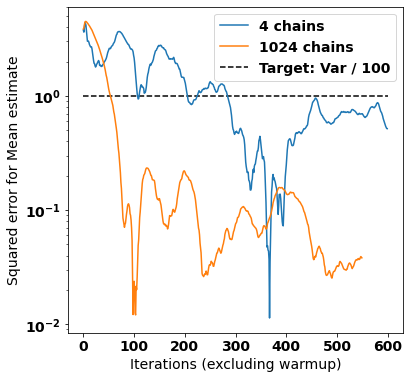

In [ ]:

# Map MCMC samples from the unconstrained space to the original space
# CHECK: does this mess up the banana example?
result_state_long = target.default_event_space_bijector(result_long.all_states)
result_state_short = target.default_event_space_bijector(result_short.all_states)

def mc_est(x, axis = 0):
  """Computes the running sample mean based on sampling iterations, with
  warmup iterations discarded.
  By default, we focus on the first parameter.
  """
  # NOTE: why discard half of the samples?
  cum_x = np.cumsum(x, axis)
  return ((cum_x[1::2] - cum_x[:cum_x.shape[0]//2]) /
         np.arange(1, cum_x.shape[0] // 2 + 1).reshape([-1] + [1] * (len(cum_x.shape) - 1)))

long_error = mc_est(result_state_long.mean(1) - mean_est)
short_error = mc_est(result_state_short.mean(1) - mean_est)

true_var_available = True
if (true_var_available):
  target_precision = jnp.linalg.norm(var_est[0] / 100)
else:
  target_precision = jnp.linalg.norm(long_error[len(long_error) - 1], axis = -1)

figure(figsize = [6, 6])
semilogy(jnp.linalg.norm(long_error, axis = -1), label = '4 chains')
semilogy(jnp.linalg.norm(short_error, axis = -1), label = '1024 chains')
hlines(target_precision, 0, total_samples_long / 2,
       linestyles = '--', 
       label = 'Target: Var / 100')
ylabel("Squared error for Mean estimate")
xlabel("Iterations (excluding warmup)")
legend(loc = 'best')
show()

I don't think the variance of the variance is stored in the inference gym, although it's probably possible to access this information using the error in the variance estimate. For now, we'll use the final result reported by the long chain as the target precision.

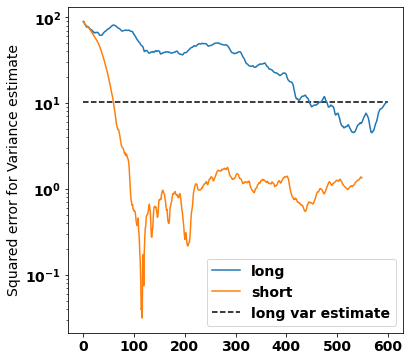

In [ ]:
long_var_error = mc_est(result_state_long.var(1)) - var_est
short_var_error = mc_est(result_state_short.var(1)) - var_est

long_var_estimate = jnp.linalg.norm(long_var_error[len(long_var_error) - 1], axis = -1)

figure(figsize = [6, 6])
semilogy(jnp.linalg.norm(long_var_error, axis = -1), label = 'long')
semilogy(jnp.linalg.norm(short_var_error, axis = -1), label = 'short')
hlines(long_var_estimate, 0, total_samples_long / 2,
       linestyles = '--', 
       label = 'long var estimate')
ylabel("Squared error for Variance estimate")
legend(loc = 'best')
show()

# NOTE: why are the estimates in the long regime so poor??

Repeat the above, using a Monte Carlo estimator based on sampling iterations with only the warmup samples discard.

In [ ]:
if (False):
  print(result_state_long[num_warmup_long:, :, :].mean(0)[0][0])
  print(result_state_short[num_warmup_short:, :, :].mean(0)[0][0])
  print(mean_est[0])
  print(long_error[len(long_error) - 1][0])
  print(short_error[len(short_error) - 1][0])

  result_state_long[num_warmup_long:, :, :].mean(1).shape

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

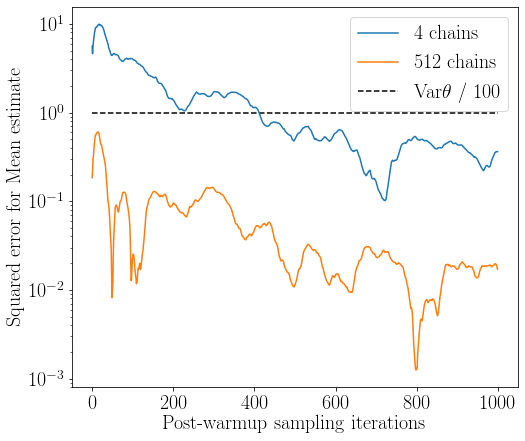

In [ ]:
def mc_est_warm(x, axis = 0):
  """ compute running average without discarding half of the samples."""
  return np.cumsum(x, axis) / np.arange(1, x.shape[0] + 1).reshape([-1] + [1] * (len(x.shape) - 1))

discard_warmup = True

if (discard_warmup):
  long_error = mc_est_warm(result_state_long[num_warmup_long:, :, :].mean(1)) - mean_est
  short_error = mc_est_warm(result_state_short[num_warmup_short:, :, :].mean(1)) - mean_est
else:
  long_error = result_state_long[num_warmup_long:, :, :].mean(1) - mean_est
  short_error = result_state_short[num_warmup_short:, :, :].mean(1) - mean_est

true_var_available = True
if (true_var_available):
  target_precision = jnp.linalg.norm(var_est[0] / 100)
else:
  target_precision = jnp.linalg.norm(long_error[len(long_error) - 1], axis = -1)

figure(figsize = [8, 7])
semilogy(jnp.linalg.norm(long_error, axis = -1), label = '4 chains')
semilogy(jnp.linalg.norm(short_error, axis = -1), label = '512 chains')
hlines(target_precision, 0, num_sampling_long,
       linestyles = '--', 
       label = r"Var$\theta$ / 100")
ylabel("Squared error for Mean estimate")
xlabel("Post-warmup sampling iterations")
legend(loc = 'best')
# show()
plt.savefig("squared_error.pdf")
files.download("squared_error.pdf")

Remark: if after one iteration we are below the target precision, than we're probably running a warmup which is too long and / or running too many chains. 

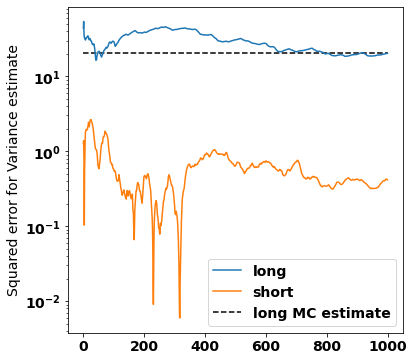

In [ ]:
long_var_error = mc_est_warm(result_state_long[num_warmup_long:, :, :].var(1)) - var_est
short_var_error = mc_est_warm(result_state_short[num_warmup_short:, :, :].var(1)) - var_est

long_var_mc_estimate = jnp.linalg.norm(long_var_error[len(long_var_error) - 1], axis = -1)

figure(figsize = [6, 6])
semilogy(jnp.linalg.norm(long_var_error, axis = -1), label = 'long')
semilogy(jnp.linalg.norm(short_var_error, axis = -1), label = 'short')
hlines(long_var_mc_estimate, 0, num_sampling_long,
       linestyles = '--', 
       label = 'long MC estimate')
ylabel("Squared error for Variance estimate")
legend(loc = 'best')
show()

Staring at the plot above it's clear that the short regime reaches a reasonable precision in fewer iterations than the long regime, even though the long regime warms up chains for many more iterations. The dotted line represent the Monte Carlo estimate using all the samples from the long regime. We'll use this as our target precision.

In [ ]:
if (False):
  print(long_mc_estimate)
  print(jnp.linalg.norm(short_error, axis = -1)[0:10])
  print(long_var_estimate)
  print(jnp.linalg.norm(short_var_error, axis = -1)[0:10])

In [ ]:
# Identify the number of iterations after which the short regime matches
# the precision of the long regime.
# TODO: find a better criterion

item_index = np.where(jnp.linalg.norm(short_error, axis = -1) <= target_precision)
target_iter_mean = item_index[0][0]
print("Reasonable precision for mean reached in", target_iter_mean + 1, "iteration(s).")

item_index = np.where(jnp.linalg.norm(short_var_error, axis = -1) <= long_var_estimate)
target_iter_var = item_index[0][0]
print("Reasonable precision for variance reached in", target_iter_var + 1, "iteration(s).")

Reasonable precision for mean reached in 1 iteration(s).
Reasonable precision for variance reached in 1 iteration(s).


### Check for convergence

Let's first examine whether we're passed the transient bias regime (we should be since we're discarding the warmup phase).

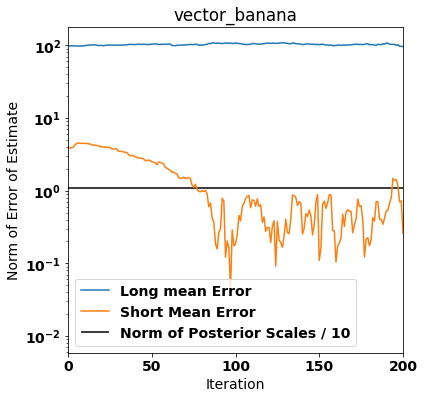

In [ ]:
# Plot last-sample estimarors
figure(figsize = [6, 6])
semilogy(jnp.linalg.norm(result_state_long.mean(1) - var_est, axis=-1),
         label='Long mean Error')
semilogy(jnp.linalg.norm(result_state_short.mean(1) - mean_est, axis=-1),
         label='Short Mean Error')
hlines(jnp.sqrt(var_est.sum() / 100), 0, total_samples_long, label='Norm of Posterior Scales / 10')
legend(loc='best')
xlabel('Iteration')
ylabel('Norm of Error of Estimate')
title(target.name)
xlim([0, 200])
show()

# NOTE: Note sure what's going on here.

Making due diligence, let's look at the samples returned by both methods, after discarding the warmup iterations.

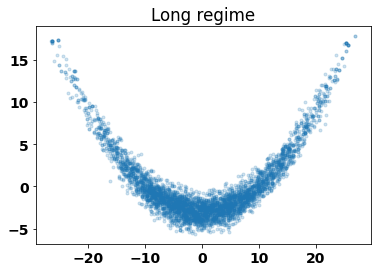

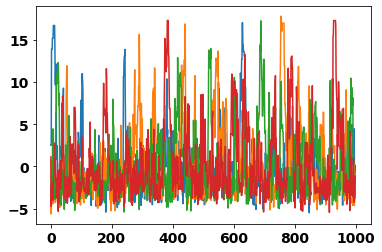

In [ ]:
plot(result_long.all_states[num_warmup_short:, :, 0].flatten(), 
     result_long.all_states[num_warmup_short:, :, 1].flatten(), '.', alpha = 0.2)
title('Long regime')
show()
plot(result_long.all_states[num_warmup_long:total_samples_long, :10, 1])
show()

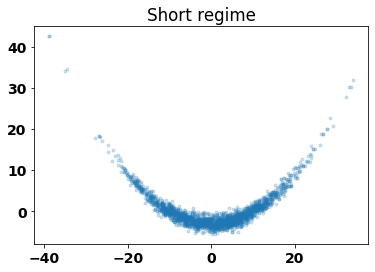

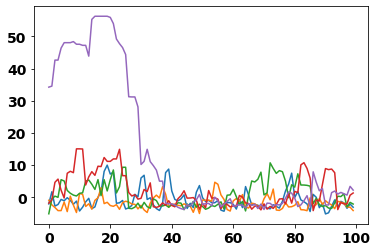

In [ ]:
# NOTE: (for Banana problem) With 4 samples after warmup we already samples spread
# out accross the parameter space.
num_samples_plot = 4  # target_iter_mean

plot(result_short.all_states[num_warmup_short:num_samples_plot + num_warmup_short, :, 0].flatten(), 
     result_short.all_states[num_warmup_short:num_samples_plot + num_warmup_short, :, 1].flatten(), '.', alpha = 0.2)

title('Short regime')
show()
plot(result_short.all_states[num_warmup_short:100 + num_warmup_short, [10, 20, 100, 500, 1000], 1])
show()

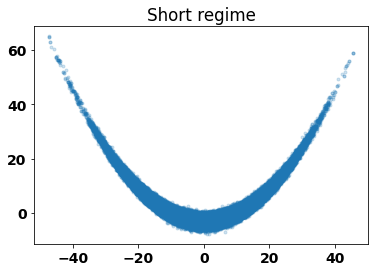

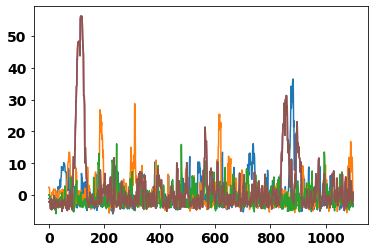

In [ ]:
# REMARK: the mixing for the banana problem is slow. This is obvious if we
# only plot the first few samples of each chain.
num_samples_plot = 4  # target_iter_mean
plot(result_short.all_states[num_warmup_short:, :, 0].flatten(), 
     result_short.all_states[num_warmup_short:, :, 1].flatten(), '.', alpha = 0.2)
title('Short regime')
show()
plot(result_short.all_states[:, [1, 200, 400, 600, 800, 1000], 1])
show()

Let's compute $\hat R$ as a function of iteration and pay attention to how quickly $\hat R$ goes to 1 in both regimes.

In [ ]:
# NOTE: the warmup is not stored.
# NOTE: compute rhat for the samples on the original space, since these are
# the quantities of interest.
def compute_rhat(result_state, num_samples, num_warmup = 0):
  return tfp.mcmc.potential_scale_reduction(result_state[num_warmup:num_warmup + num_samples + 1],
                                          independent_chain_ndims = 1).T

# TODO: do this without a for loop
# WARNING: this cell takes a minute to run
# TODO: use a single variable num_sampling, instead of num_sampling_long and
# num_sampling_var.
rhat_long = np.array([])
rhat_short = np.array([])
range_iter = range(2, num_sampling_long, 10) # range(2, num_samples, 8)

# NOTE: depending on the problem, it can be interesting to look at both.
# However, to be consistent with earlier analysis, the warmup samples should
# be discarded.
discard_warmup = True

for i in range_iter:
  if (discard_warmup):
    discard_long = num_warmup_long
    discard_short = num_warmup_short
  else:
    discard_long = 0
    discard_short = 0
  rhat_long = np.append(rhat_long, 
                        compute_rhat(result_state_long, i, discard_long)[0, ])
  rhat_short = np.append(rhat_short,
                          compute_rhat(result_state_short, i, discard_short)[0, ])


Remark: the $\hat R$ estimate can be quite noisy, especially when computed with a small number of samples. One manifestation of this is the fact that $\hat R < 1$. In the German credit score model, $\hat R$ is as low as 0.6!! When this is the case, $\hat R$ will typically be large for other parameters. Hence, inspecting many parameters (presumably all of interest) can safeguard us against crying "victory" too early.

This type of noise can explain why the change in $\hat R$ isn't always quite monotone, sometimes with an increase at first, and then the expected decrease.

In [ ]:
result_snip = result_state_long[num_warmup_long:num_warmup_long + 2]
tfp.mcmc.potential_scale_reduction(result_snip, independent_chain_ndims = 1).T

DeviceArray([4.502508 , 1.2932507], dtype=float32)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

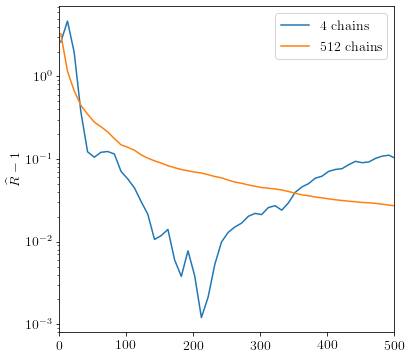

In [ ]:
# Plot result
figure(figsize = [6, 6])
semilogy(np.array(range_iter), rhat_long - 1, label = '4 chains')
semilogy(np.array(range_iter), rhat_short - 1, label = '512 chains')
legend(loc = 'best')
xlim([0, 500])
ylabel("$\widehat R- 1$")
# show()
plt.savefig("Rhat_over_iter.pdf")
files.download("Rhat_over_iter.pdf")

(Banana example) As expected, $\hat R$ decreases with the number of iterations per chain, although crucially not with the *total number of samples*! As one might suspect, the short regime produces a less noisy estimate of $\hat R$. To be more precise, we expect $\hat R$ to decrease with the *effective sample size per chain*. Since the long regime benefits from a longer warmup, the effective sample size per iteration should be better, although it might not make a difference in this example.

Crucially, $\hat R$ as a convergence diagnostic isn't sensitive to the fact we are running many chains (although the estimator does become less noisy...).



In [ ]:
# Compare Rhat at the point where both methods have reached a comparable squared
# error.
# NOTE: not super reliable -- sometimes rhat is noisy and goes to 1 (or below)
# before jumping back up...
index = np.where(range_iter > target_iter_mean)[0][0]
print("Rhat for short regime after hitting target precision:", rhat_short[index])
print("Rhat for long regime after hitting target precision:", rhat_long[len(rhat_long) - 1])


Rhat for short regime after hitting target precision: 4.299034595489502
Rhat for long regime after hitting target precision: 1.023927092552185


**Proposition:** Concerned with how noisy $\hat R$ might be, let's use a bootstrap scheme to get a standard deviation on the estimator. The short regime should be amiable to this, since we can resample chains. Unfortunately, if we sample with replacement, we underestimate the between chain variance, because some of the chains are identical. One idea is to randomly sample a subset of the chains without replacement and compute $\hat R$.
This will overestimate the uncertainty in our calculations, since we have reduced the sample size.

In [ ]:
n_bootstrap_samples = 64  # 64
rhat_estimates = np.array([])
n_sampling_iter = max(range_iter[index], 2)  # max(target_iter_mean, 2) # range_iter[index]

for i in range(1, n_bootstrap_samples):
  choose_samples_randomly = True
  if (choose_samples_randomly):
    bootstrap_sample = np.random.choice(np.array(range(1, num_chains_short + 1)),
                                        n_bootstrap_samples, replace = False)
                                        # num_chains_short // 16, replace = False)
  else:
    bootstrap_sample = np.array(range(1 + (i - 1) * n_bootstrap_samples, i * n_bootstrap_samples))
  # print(bootstrap_sample)
  # print(result_state_short[:, bootstrap_sample, :].shape)
  rhat_estimates = np.append(rhat_estimates,
      compute_rhat(result_state_short[:, bootstrap_sample, :], n_sampling_iter, num_warmup_short)[0, ])

print("Mean rhat (short) = ", rhat_estimates.mean(), "+/-", rhat_estimates.std())


Mean rhat (short) =  4.7100193954649425 +/- 1.069936839726212


## Nested $\hat R$

To remedy the identified issue, we propose to pool chains together in the short regime, thereby building super-chains, and then checking that the super chains are mixing.

We index each sample by $n$ the iteration, $m$ the chain, and $k$ the cluster of chains, and write $\theta^{(n, m, k)}$. The within-chain variance is estimated by
$$
  s^2_{km} = \frac{1}{N - 1} \sum_{n = 1}^N \left (\theta^{(nmk)} - \bar \theta^{(.mk)} \right)^2.
$$

Next the between-chain variance, or within super chain variance is
\begin{eqnarray}
  s^2_{k.} & = & \frac{1}{M - 1} \sum_{m = 1}^M \left (\bar \theta^{(.mk)} - \bar \theta^{(..k)} \right)^2,
\end{eqnarray}
and the total variance for a super chain is
\begin{eqnarray}
  S^2_k & = & \frac{1}{M - 1} \sum_{m = 1}^M \left (\bar \theta^{(.mk)} - \bar \theta^{(..k)} \right)^2 + \frac{1}{M (N - 1)} \sum_{m = 1}^M \sum_{n = 1}^N \left (\theta^{(nmk)} - \bar \theta^{(.mk)} \right)^2 \\
  & = & s^2_{k.} + \frac{1}{M} \sum_{m = 1}^M s^2_{km}
\end{eqnarray}
Notice that this calculation accounts for the fact the super-chain is made up of multiple chains.
Finally the within-super-chain variance is estimated as
$$
W = \frac{1}{K} \sum_{k = 1}^K S^2_k.
$$

Now it remains to compute the between super-chain variance
$$
B = \frac{1}{K - 1} \sum_{k = 1}^K \left (\bar \theta^{(..k)} - \bar \theta^{(...)} \right)^2,
$$
yielding an estimate of the posterior variance
$$
  \widehat{\mathrm{var}}^+(\theta) = B + W,
$$
which very much looks like the posterior variance estimate used in the in the long regime, except that I've been a bit more consistent about making the estimator unbiased. We then compute

$$
  \hat R = \sqrt{\frac{\widehat{\mathrm{var}}^+(\theta)}{W}}.
$$

*Remark.* The $\theta$ can be replaced by the rank-normalized $z$ as presrcribed by [Vehtari et al 2020](https://arxiv.org/abs/1903.08008).





### Implementation of nested-$\hat R$ using TensorFlow.


In [ ]:
# Remark: eager execution is disabled and would have to be enabled at the
# start of the program. I however suspect this would interfere with
# TensorFlow probability.
tf.executing_eagerly()

True

In [ ]:
# Follow procedure described in source code for potential scale reduction.
# NOTE: some of the tf argument need to be adjusted (e.g. keepdims = False,
# instead of True). Not quite sure why.
# QUESTION: can these be accessed as internal functions of tf?
# TODO: following Pavel's example, rewrite this without using tf.
# TODO: add error message when the number of samples is less than 2.

# REMARK: this function doesn't seem to work, returns NaN.
# As a result, can only use _reduce_variance with biased =  False.
def _axis_size(x, axis = None):
  """Get number of elements of `x` in `axis`, as type `x.dtype`."""
  if axis is None:
    return ps.cast(ps.size(x), x.dtype)
  return ps.cast(
      ps.reduce_prod(
          ps.gather(ps.shape(x), axis)), x.dtype)

def _reduce_variance(x, axis=None, biased=True, keepdims=False):
  with tf.name_scope('reduce_variance'):
    x = tf.convert_to_tensor(x, name='x')
    mean = tf.reduce_mean(x, axis=axis, keepdims=True)
    biased_var = tf.reduce_mean(
        tf.math.squared_difference(x, mean), axis=axis, keepdims=keepdims)
    if biased:
      return biased_var
    n = _axis_size(x, axis)
    return (n / (n - 1.)) * biased_var

def nested_rhat(result_state, num_super_chain):
  used_samples = result_state.shape[0]
  num_sub_chains = result_state.shape[1] // num_super_chains
  num_dimensions = result_state.shape[2]

  chain_states = result_state.reshape(used_samples, -1, num_sub_chains,
                                      num_dimensions)

  state = tf.convert_to_tensor(chain_states, name = 'state')
  mean_chain = tf.reduce_mean(state, axis = 0)
  mean_super_chain = tf.reduce_mean(state, axis = [0, 2])
  variance_chain = _reduce_variance(state, axis = 0, biased = False)
  variance_super_chain = _reduce_variance(mean_chain, axis = 1, biased = False) \
     + tf.reduce_mean(variance_chain, axis = 1)

  W = tf.reduce_mean(variance_super_chain, axis = 0)
  B = _reduce_variance(mean_super_chain, axis = 0, biased = False)

  return tf.sqrt((W + B) / W)


### CASE 1 (sanity check): $\hat R$ after a few iterations
The super chains are such that they have the same number of samples as the chains in the long regime. Because of the slow mixing, 4 iterations per chain is not enough to overcome the transient bias and the nested Rhat is high, even though each super chain has many iterations. Note we're looking at the first warmup iterations.

In [ ]:
# num_super_chains = 4
# super_chain_size = num_chains_short // num_super_chains  # 250
used_samples = 4  # total_samples_long // super_chain_size  # 4
result_state = result_short.all_states[0:used_samples, :, :]

print("short rhat: ", nested_rhat(result_state, num_super_chains))

short rhat:  tf.Tensor([3.3712056 1.4704777], shape=(2,), dtype=float32)


### CASE 2: $\hat R$ after "enough" iterations
The number of iterations in each chain corresponds to the number of samples required by the short regime to match the precision for the mean attained by the long regime after 1000 sampling iterations (meaning we've discarded the warmup iterations). The diagnostic is quite happy, even though there are only two iterations per chain.

In [ ]:
result_state.shape
target_iter_mean

0

In [ ]:
used_samples = max(target_iter_mean, 2)
result_state = result_short.all_states[num_warmup_short:num_warmup_short + used_samples, :, :]

print("short nested-rhat: ", nested_rhat(result_state, num_super_chains)[0])
print("short rhat: ", rhat_short[index])
print("long rhat: ", rhat_long[len(rhat_long) - 1])

short nested-rhat:  tf.Tensor(1.0011653, shape=(), dtype=float32)
short rhat:  4.299034595489502
long rhat:  1.023927092552185


In [ ]:
print(range_iter)

range(2, 1000, 10)


In [ ]:
# Let's find out how quickly nested-rhat compared to traditional rhat goes down.
nested_rhat_short = np.array([])
for i in range_iter:
    nested_rhat_short = np.append(nested_rhat_short, 
                                  nested_rhat(result_short.all_states[num_warmup_short:num_warmup_short + i, :, :],
                                              num_super_chains).numpy()[0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

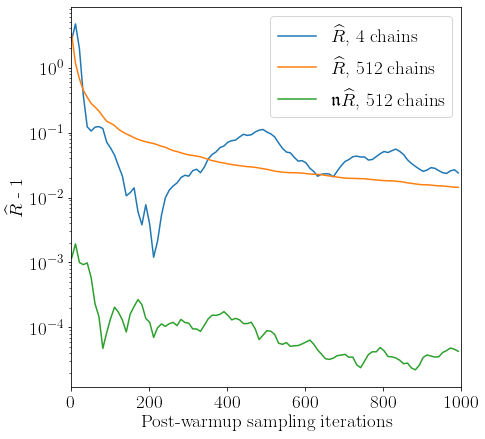

In [ ]:
plt.figure(figsize = [7, 7])
plt.semilogy(np.array(range_iter), rhat_long - 1, label = '$\\widehat{R}$, 4 chains')
plt.semilogy(np.array(range_iter), rhat_short - 1, label = '$\\widehat{R}$, 512 chains')
plt.semilogy(np.array(range_iter), nested_rhat_short - 1, label = '$\\mathfrak n \widehat R$, 512 chains')
plt.legend(loc = 'best')
plt.xlim([0, 1000])
plt.ylabel("$\widehat R$ - 1")
plt.xlabel("Post-warmup sampling iterations")
#show()
plt.savefig("nRhat_over_iter.pdf")
files.download("nRhat_over_iter.pdf")

In [ ]:

threshold = 1.1
index_classic = np.where((rhat_short < threshold) & (rhat_short > 1.))
if (len(index_classic[0]) > 0):
  print("Rhat =", threshold, "after",range_iter[index_classic[0][0]], "iterations.")
else:
  print("Rhat doesn't hit the target threshold = ", threshold, ".")


index_short = np.where((nested_rhat_short < threshold) & (nested_rhat_short > 1.))
if (len(index_short[0]) > 0):
  print("Nested Rhat =", threshold, "after", range_iter[index_short[0][0]], "iterations.")
else:
  print("Nested Rhat doesn't hit the target threshold = ", threshold, ".")

threshold = 1.01
index_classic = np.where((rhat_short < threshold) & (rhat_short > 1.))
if (len(index_classic[0]) > 0):
  print("Rhat =", threshold, "after",range_iter[index_classic[0][0]], "iterations.")
else:
  print("Rhat doesn't hit the target threshold = ", threshold, ".")

index_short = np.where((nested_rhat_short < threshold) & (nested_rhat_short > 1.))
if (len(index_short[0]) > 0):
  print("Nested Rhat =", threshold, "after", range_iter[index_short[0][0]], "iterations.")
else:
  print("Nested Rhat doesn't hit the target threshold = ", threshold, ".")

# Effective sample size
We'll now compute the effective sample size. We might in fact expect the classic diagnostic to work relatively well.

In [ ]:
ess_long = np.sum(tfp.mcmc.effective_sample_size(
    result_state_long[num_warmup_long:, : , :]), axis = 0)

ess_short = np.sum(tfp.mcmc.effective_sample_size(
    result_state_short[num_warmup_short:, :, :]), axis = 0)

ess_short_target = np.sum(tfp.mcmc.effective_sample_size(
    result_state_short[num_warmup_short:num_warmup_short + 3, :, :]), axis = 0)

# NOTE: it seems we need at least 3 samples to compute the ess estimate...

print("Ess long (discarding warmup): ", ess_long[0])
print("Ess short (discarding warmup): ", ess_short[0])
print("Ess short (when hitting target precision): ", ess_short_target[0])

# Adaptive warmup length
Playing around a little, we find that once the algorithm is properly warmed up, the short regime can reach good precision in very few iterations. The primary limitation hence becomes the warm up time.

Proper warmup means (i) we've overcomed the transient bias and have already moved across the "typical set" -- it isn't enough to be in the "typical set" if where we are is determined by our starting point -- and (ii) our algorithm tuned well-enough such that it can explore every part of the parameter space in a reasonable time and has a relatively short relaxation time. The first item is essential to both sampling regimes, though intuitively, it seems we might be able to compromise on the second item in the short regime.

In many cases, the number of warmup samples is determined ahead of time when calling the algorithm. Ideally we'd stop the warmup once we have suitable tuning parameters and then move to the sampling phase. [Zhang et al (2020)](https://metrumrg.com/wp-content/uploads/2020/11/ZhangY_ACOP2020_BayesianWarmUpMethods.pdf) propose to run warmups over short windows of $w = 100$ iterations and compute $\hat R$ and the ESS at the end of each of window to check if we should continue warming up. Once both diagnostic estimates are passed a certain threshold, the warmup ends and the sampling begins. In theory, this scheme can be adapted to the short regime by replacing $\hat R$ with the nested $\hat R$.

My guess is that by using nested $\hat R$ and the classic ESS (computed using many independent chains) we'll implicitly compromise on item (ii) -- so *a priori*, the described warmup method requires little adjustment.

In [ ]:
# Define function to extract the adapted parameters
# (Follow what's done in the inference gym tutorial)
# REMARK: if we pass only initial step size, only one step size is adapted for 
# the whole transition kernel (as opposed to one step size per chain).
# REMARK: we won't use this scheme. Instead, we'll pass the whole transition.
from tensorflow_probability.python.internal.unnest import get_innermost


# NOTE: presumable we're not going to use this, and instead get the full
# kernel result back.
def trace_fn(_, pkr):
  return (
      get_innermost(pkr, 'step_size'),
      get_innermost(pkr, 'num_leapfrog_steps')
      # get_innermost(pkr, 'max_trajectory_length')
  )

In [ ]:

def forge_chain (target_rhat, warmup_window_size, kernel_cold, initial_state,
                 max_num_steps, seed, monitor = False,
                 use_nested_rhat = True, use_log_joint = False,
                 num_super_chains = 4):
  # store certain variables
  rhat_forge = np.array([])
  warmup_is_acceptable = False
  store_results = []

  warmup_iteration = 0

  current_state = initial_state
  final_kernel_args = None

  while (not warmup_is_acceptable and warmup_iteration <= max_num_steps):
    warmup_iteration += 1

    # 1) Run MCMC on short warmup window
    result_cold, target_log_prob, final_kernel_args = tfp.mcmc.sample_chain(
        num_results = warmup_window_size,
        current_state = current_state,
        kernel = kernel_cold,
        previous_kernel_results = final_kernel_args,
        seed = kernel_seed,
        trace_fn = lambda _, pkr: unnest.get_innermost(pkr, 'target_log_prob'),
        return_final_kernel_results = True)

    if (warmup_iteration == 1) : 
      store_results = result_cold
    else : 
      store_results = np.append(store_results, result_cold, axis = 0)

    current_state = result_cold[-1]

    # 2) Check if warmup is acceptable
    if (used_nested_rhat):
      if (use_log_joint):
        shape_lp = target_log_prob.shape
        rhat_warmup = nested_rhat(target_log_prob.reshape(shape_lp[0], shape_lp[1], 1),
                                  num_super_chains)
      else:
        rhat_warmup = max(nested_rhat(result_cold, num_super_chains))
    else:
      if (use_log_joint):
        rhat_warmup = tfp.mcmc.potential_scale_reduction(target_log_prob)
      else:
        rhat_warmup = max(tfp.mcmc.potential_scale_reduction(result_cold))
    # ess_warmup = np.sum(tfp.mcmc.effective_sample_size(result_cold), axis = 0)

    # print(rhat_warmup)

    if (rhat_warmup < target_rhat): warmup_is_acceptable = True
    # if (max(rhat_warmup) < 1.01 and min(ess_warmup) > 100): warmup_is_acceptable = True

    if (monitor):
      print("step:", final_kernel_args.step)
      # print("max rhat:", max(rhat_warmup))
      # print("min ess warmup:" , min(ess_warmup))
      # print("step size:", step_size)
      # print("number of leapfrog steps:", num_leapfrog_steps)
  
    save_values = True
    if (save_values):
      rhat_forge = np.append(rhat_forge, rhat_warmup)
    # While loop ends

  return store_results, final_kernel_args, rhat_forge


In [ ]:
# Set up adaptive warmup scheme
warmup_window_size = 5
target_rhat = 1.01
target_ess = 100
max_num_steps = 1000 // warmup_window_size
current_state = initial_state
num_leapfrog_steps = 1
warmup_iteration = 0
kernel_seed = random.PRNGKey(1957)

used_nested_rhat = True

# define kernel using most recent step size
kernel_cold = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, init_step_size, 1)
kernel_cold = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(kernel_cold, warmup_window_size)
kernel_cold = tfp.mcmc.DualAveragingStepSizeAdaptation(
      kernel_cold, warmup_window_size, target_accept_prob = 0.75,
      reduce_fn = tfp.math.reduce_log_harmonic_mean_exp)

kernel_warm = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, init_step_size, 1)
kernel_warm = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(kernel_warm, 0)
kernel_warm = tfp.mcmc.DualAveragingStepSizeAdaptation(
      kernel_warm, warmup_window_size, target_accept_prob = 0.75,
      reduce_fn = tfp.math.reduce_log_harmonic_mean_exp)


In [ ]:
result_cold, final_kernel_args, rhat_forge = \
  forge_chain(target_rhat = target_rhat,
              warmup_window_size = warmup_window_size,
              kernel_cold = kernel_cold,
              initial_state = initial_state,
              max_num_steps = max_num_steps,
              seed = random.PRNGKey(1954), monitor = False,
              use_nested_rhat = True,
              use_log_joint = True)


In [ ]:
print("iterations:", len(rhat_forge) * warmup_window_size)
print(rhat_forge)
print(target_rhat)
# print(tfp.mcmc.potential_scale_reduction(result_cold[-50]))
# print(nested_rhat(result_short.all_states[num_warmup_short:num_warmup_short + 5, :, :], num_super_chains))

In [ ]:
# Run sampling iterations
# def trace_fn(_, pkr):
#   return (
#       get_innermost(pkr, 'unnormalized_log_prob'))

current_state = result_cold[-1]

result_warm, target_log_prob, final_kernel_args_warm = tfp.mcmc.sample_chain(
      num_results = 5,
      current_state = current_state,
      kernel = kernel_warm, # kernel_cold
      previous_kernel_results = final_kernel_args,
      seed = random.PRNGKey(100001),
      return_final_kernel_results = True,
      trace_fn = lambda _, pkr: unnest.get_innermost(pkr, 'target_log_prob'))

In [ ]:
print(tfp.mcmc.potential_scale_reduction(target_log_prob))
# print(nested_rhat(target_log_prob, num_super_chains))
shape_lp = target_log_prob.shape
lp__ = target_log_prob.reshape(shape_lp[0], shape_lp[1], 1)
lp__.shape
print(nested_rhat(lp__, num_super_chains))

In [ ]:
print(tfp.mcmc.potential_scale_reduction(result_warm))
nested_rhat(result_warm, num_super_chain = num_super_chains)

In [ ]:
# options: result_cold[result_cold.shape[0] - 30:], result_state_short, result_warm, store_results
states_to_read = result_warm

print("mean estimate:", np.mean(states_to_read.mean(0), axis = 0))
print("variance estimate:", np.mean(states_to_read.var(1), axis = 0))
print(nested_rhat(states_to_read, num_super_chain = 4))
print(tfp.mcmc.potential_scale_reduction(states_to_read))
print(mean_est)
print(var_est)

In [ ]:
# Check output of the last run

plot(result_warm[:, :, 0].flatten(), 
     result_warm[:, :, 1].flatten(), '.', alpha = 0.2)
title('Long regime')
show()
plot(result_warm[:, :30, 1])
show()

# Compare to output we get with uninterrupted run.
# (Examine the iterations before the warmup ends)
chain_state_short = result_short.all_states[num_warmup_short - 10:num_warmup_short - 10 + warmup_window_size, :, :]
plot(chain_state_short[:, :, 0].flatten(),
     chain_state_short[:, :, 1].flatten(), '.', alpha = 0.2)
show()

plot(chain_state_short[:, :30, 1])
show()

## Experiment with window size

The code below returns the length of the warmup phase, simulated accross several seeds. This can give us a sense of how long the warmup phase is on average for different seeds. Be mindful that when using too many seeds with a lot of chains, the GPU can run out of memory. The motivation is to check how stable the warmup strategy is when using different window sizes.


In [ ]:
target_rhat = 1.01
warmup_window_size = 30
max_num_steps = 1000 // warmup_window_size

iteration_after_warmup = np.array([])

for seed in jax.random.split(jax.random.PRNGKey(0), 10):
  initial_state = initialize((num_super_chains,), key = seed)
  initial_state = np.repeat(initial_state, num_chains_short // num_super_chains,
                            axis = 0)

  result_cold, final_kernel_args, rhat_forge = \
    forge_chain(target_rhat = target_rhat,
                warmup_window_size = warmup_window_size,
                kernel_cold = kernel_cold,
                initial_state = initial_state,
                max_num_steps = max_num_steps,
                seed = seed, monitor = False,
                use_nested_rhat = True,
                use_log_joint = False)
    
  iteration_after_warmup = np.append(iteration_after_warmup,
                                     len(rhat_forge) * warmup_window_size)


In [ ]:
# print(iteration_after_warmup)
print(rhat_forge)
print(iteration_after_warmup.mean())
print(iteration_after_warmup.std())

### Results for the Banana problem
Applying the code above for the banana problem with
```
target_rhat = 1.01
use_nested_rhat = True
use_log_joint = False
```
we estimate the length of the warmup phase for different window sizes:
```
w = 10, length = 62 +/- 16.12
w = 15, length = 72 +/- 17.41
w = 20, length = 86 +/- 18
w = 30, length = 90 +/- 13.75
w = 60, length = 120 +/- 0.0
```
Taking into consideration the different granularities, we find the results to be fairly consistent with one another.

Let's go back to the original case where we use $\hat R$ and ESS as our stoping criterion. Given the approximate one-to-one map between $\hat R$ and ESS per chain, the two criterion are somewhat redundant, so I'll focus on $\hat R$. When picking the window size, we must contend with the following trade-off:
* if the window size is too short, we're unlikely to produce a large enough ESS per chain to hit the target $\hat R$, and this could mean a never-ending warmup phase, or one that only stops once we exceed a maximum number of steps.
* if the window size is too large, we may jump pass the optimal point. It's also worth noting that the first window is unlikely to yield satisfactory results, because the intial estimates are overdispered and bias. 

The first item is largely mitigated by using nested-$\hat R$, since we're then less dependent on the ESS per chain. The second item could be addressed by using a path-finder to initialize the chains and/or by discarding some of the early iterations in a window when computing the diagnostics. 

One final remark is that using $\hat R$ on the log joint distribution yielded somewhat optimistic results. As Pavel puts it: "log_joint is a pretty bad metric. Generally, for convergence, you prefer to measure the least constrainted directions, and log_joint is typically not that."


## Draft Code

In [ ]:
 
result_cold, _, final_kernel_args = tfp.mcmc.sample_chain(
      num_results = 100,
      current_state = initial_state,
      kernel = kernel_cold,
      previous_kernel_results = None,
      seed = random.PRNGKey(1954),
      return_final_kernel_results = True)

result_warm, _, final_kernel_args = tfp.mcmc.sample_chain(
    num_results = 50,
    current_state = result_cold[-1],
    kernel = kernel_warm,
    previous_kernel_results = final_kernel_args,
    seed = random.PRNGKey(1954),
    return_final_kernel_results = True)


In [ ]:
nested_rhat(result_warm[1:3], 4)

In [ ]:
warmup_window_size = 200
current_state = initial_state

kernel_warm = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, init_step_size, 1)
kernel_warm = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(kernel_warm, warmup_window_size)
kernel_warm = tfp.mcmc.DualAveragingStepSizeAdaptation(
    kernel_warm, warmup_window_size, target_accept_prob = 0.75,
    reduce_fn = tfp.math.reduce_log_harmonic_mean_exp)

# result_warm, (step_size_saved, num_leapfrog_steps_saved) = tfp.mcmc.sample_chain(
#   warmup_window_size, current_state, kernel = kernel_warm,
#   seed = random.PRNGKey(1954), trace_fn = trace_fn)

result_warm, kernel_args, final_kernel_args = tfp.mcmc.sample_chain(
    warmup_window_size, current_state, kernel = kernel_warm,
    seed = random.PRNGKey(1954), return_final_kernel_results = True)


In [ ]:
# step_size = step_size_saved[warmup_window_size - 1]
# current_state = result_warm[warmup_window_size - 1, :, :]
# num_leapfrog_steps = num_leapfrog_steps_saved[warmup_window_size - 1]

tfp.mcmc.potential_scale_reduction(result_warm[:, :, :])

In [ ]:
# kernel_warm2 = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, step_size, num_leapfrog_steps)
# kernel_warm2 = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(kernel_warm2, warmup_window_size)
# kernel_warm2 = tfp.mcmc.DualAveragingStepSizeAdaptation(
#     kernel_warm2, warmup_window_size, target_accept_prob = 0.75,
#     reduce_fn = tfp.math.reduce_log_harmonic_mean_exp)

# result_warm2, (step_size_saved) = tfp.mcmc.sample_chain(
#   warmup_window_size, current_state, kernel = kernel_warm2,
#   seed = random.PRNGKey(1954), trace_fn = trace_fn)

result_warm2 = tfp.mcmc.sample_chain(
    num_results = warmup_window_size, 
    kernel = kernel_warm,
    current_state = current_state,
    previous_kernel_results = final_kernel_args,
    seed = random.PRNGKey(1953)
)

In [ ]:
tfp.mcmc.potential_scale_reduction(result_warm2.all_states[:, :, :])

In [ ]:
print(problem_name)

print(max(rhat_warmup))
print(min(ess_warmup))
# print(len(step_size))
# print(step_size[0][warmup_window_size - 1])
max(tfp.mcmc.potential_scale_reduction(result_warm))

In [ ]:
# Define kernel for warmup windows (should be the same in the long and short regime)
warmup_window_size = 10

if (problem_name == 'Bananas' or problem_name == 'GermanCredit'):
  kernel_warm_init = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, init_step_size, 1)
  kernel_warm_init = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(kernel_warm_init, warmup_window_size)
  kernel_warm_init = tfp.mcmc.DualAveragingStepSizeAdaptation(
      kernel_warm_init, warmup_window_size, target_accept_prob = 0.75,  #0.75,
      reduce_fn = tfp.math.reduce_log_harmonic_mean_exp)


In [ ]:
result_warm, (step_size, max_trajectory_length) = tfp.mcmc.sample_chain(
  warmup_window_size, initial_state, kernel = kernel_warm_init, seed = random.PRNGKey(1954),
  trace_fn = trace_fn)

In [ ]:
print(step_size[len(step_size) - 1])
print(max_trajectory_length[len(max_trajectory_length) - 1])
print(initial_state.shape)
print(result_warm[warmup_window_size, :, :])

In [ ]:
# To run next window, define a new transition kernel
# REMARK: the maximum trajectory length isn't, if my understanding is correct,
# a tuning parameter; rather something that get's calculated at each step. So
# there's no need to pass it on.
kernel_warm = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, step_size[len(step_size) - 1], 1)
kernel_warm = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(kernel_warm, warmup_window_size)
kernel_warm = tfp.mcmc.DualAveragingStepSizeAdaptation(
    kernel_warm_init, warmup_window_size, target_accept_prob = 0.75,
    reduce_fn = tfp.math.reduce_log_harmonic_mean_exp)

In [ ]:
result_warm2, (step_size, max_trajectory_length) = tfp.mcmc.sample_chain(
  warmup_window_size, initial_state, kernel = kernel_warm, seed = random.PRNGKey(1954),
  trace_fn = trace_fn)

In [ ]:
print(result_warm.shape)
print(step_size.shape)
print(max_trajectory_length.shape) 

In [ ]:
step_size[len(step_size) - 1]

In [ ]:
# nested_rhat(result_short.all_states, num_super_chains)

In [ ]:
## Sandbox

# Pool chains into super chains
# num_super_chains = 4  # num_chains_short // num_chains_long
# num_sub_chains = num_chains_short // num_super_chains
# used_samples = num_samples # 5  # 2 * target_iter_mean  # target_iter_mean
# result_state = result_short.all_states[0:used_samples, :, :]
# chain_states = result_state.reshape(used_samples, num_sub_chains,
#                                     -1, num_dimensions)

# independent_chains_ndims = 1
# sample_ndims = 1
# sample_axis = tf.range(0, sample_ndims)
# chain_axis 

In [ ]:
  # used_samples = result_state.shape[0]
  # num_sub_chains = result_state.shape[1] // num_super_chains
  # num_dimensions = result_state.shape[2]

  # chain_states = result_state.reshape(used_samples, -1, num_sub_chains,
  #                                    num_dimensions)

  # state = tf.convert_to_tensor(chain_states, name = 'state')

  # mean_chain = tf.reduce_mean(state, axis = 0)
  # mean_super_chain = tf.reduce_mean(state, axis = [0, 2])
  # variance_chain = _reduce_variance(state, axis = 0, biased = False)
  # variance_super_chain = _reduce_variance(mean_chain, axis = 1, biased = False) \
  #    + tf.reduce_mean(variance_chain, axis = 1)

  # W = tf.reduce_mean(variance_super_chain, axis = 0)
  # B = _reduce_variance(mean_super_chain, axis = 0, biased = False)

  # rhat = tf.sqrt((W + B) / W)

  # print(rhat)

  # print(mean_chain.shape)
  # print(mean_super_chain.shape)
  # print("mean_super_chain: ", mean_super_chain)
  # print(variance_chain.shape)
  # print(variance_super_chain.shape)

In [ ]:
# print(state.shape)  # (5, 250, 4, 2)
# print(result_state.shape)  # (5, 1000, 2)

In [ ]:
# # 'manually' compute the mean of each super chain.
# print(np.mean(result_state[:, 0:250, 0]))
# print(np.mean(result_state[:, 250:500, 0]))
# print(np.mean(result_state[:, 500:750, 0]))
# print(np.mean(result_state[:, 750:1000, 0]))

# # compute the means after reshaping the results. Get agreement!
# print(np.mean(chain_states[:, 0, :, 0]))
# print(np.mean(chain_states[:, 1, :, 0]))
# print(np.mean(chain_states[:, 2, :, 0]))
# print(np.mean(chain_states[:, 3, :, 0]))

In [ ]:
# print(result_state[:, 250, 0])
# print(chain_states[:, 0, 1, 0])

In [ ]:
# simple_chain = np.array([[0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]])
# simple_chain.shape  # (4, 6)

# chain_reshape = simple_chain.reshape(4, 2, -1)
# chain_reshape.shape  # (4, 2, 3)
# np.mean(chain_reshape, axis = 0)  # returns mean for each chain
# np.mean(chain_reshape[:, 0, :])  # 1
# np.mean(chain_reshape[:, 1, :])  # 4

# np.mean(simple_chain[:, 0:2])  # 1
# np.mean(simple_chain[:, 3:6])  # 4 -- but it seems index should be 3:5
# # simple_chain[:, 3:6]

In [ ]:
# ## Sandbox

# tf.compat.v1.disable_eager_execution() # need to disable eager in TF2.x

# state = result_short.all_states[1:range_iter[index], :, :]
# n = state.shape[0]
# m = state.shape[1]

# sample_ndims = 1
# independent_chains_ndims = 1
# sample_axis = tf.range(0, sample_ndims)  # CHECK
# chain_axis = 0
# sample_and_chain_axis = tf.range(0, sample_ndims + independent_chains_ndims)  # CHECK


# with tf.name_scope('potential_scale_reduction_single_state'):
#   state = tf.convert_to_tensor(state, name = 'state')

#   # CHECK: do we need to define a tf scope?
#   n_samples = tf.compat.dimension_value(state.shape[0])

#   # n = _axis_size(state, sample_axis)
#   # m = _axis_size(state, chain_axis)

#   # NOTE: These lines prompt the error message once the session is run.
#   # x = tf.reduce_mean(state, axis=sample_axis, keepdims=True)
#   # x_tf = tf.convert_to_tensor(x, name = 'x')
#   # n_tf = _axis_size(x_tf)

#   b_div_n = _reduce_variance(
#       tf.reduce_mean(state, axis = 0, keepdims = False),
#       sample_and_chain_axis,  # sample and chain axis
#       biased = False
#   )

#   w = tf.reduce_mean(
#       _reduce_variance(state, sample_axis, keepdims = False, 
#                        biased = False),
#       axis = sample_and_chain_axis
#   )

#   # TODO: work out n and m from the number of chains being passed.
#   # n = target_iter_mean
#   # m = num_chains
#   sigma_2_plus = ((n - 1) / n) * w + b_div_n
#   rhat = ((m + 1.) / m) * sigma_2_plus / w - (n - 1.) / (m * n)


# # Launch the graph in a session. (TensorFlow uses differed action,
# # so need to explicitly request evaluation)
# sess = tf.compat.v1.Session()

# print(sess.run(rhat))